# Project McNulty: Predicting activity with physics

Gretta Ferguson

10/17/18

## Table of Contents

1. Import and format data
2. Visualize the data using PCA
3. Use GroupKFold to create a CV split
4. Tune parameters on full feature space
5. Tune parameters on limited feature space
6. Testing our chosen model
    

-----------
-----------
-----------
## 1. Import and format data

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier


# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel
# from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV, cross_val_predict

from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from scipy import interp
from sklearn.naive_bayes import BernoulliNB

from sklearn.ensemble import ExtraTreesClassifier


from skopt import BayesSearchCV
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')


In [39]:
features = pd.read_csv('HAPT Data Set/features.txt', delim_whitespace=True, header=None)
activity = pd.read_csv('HAPT Data Set/activity_labels.txt', delim_whitespace=True, header=None)
subject = pd.read_csv('HAPT Data Set/train/subject_id_train.txt', delim_whitespace=True, header=None)
X_train = pd.read_csv('HAPT Data Set/train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('HAPT Data Set/train/y_train.txt', delim_whitespace=True, header=None)

In [3]:
y_train.columns=["ActivityID"]
activity.columns=["ActivityID","Activity"]
subject.columns=["SubjectID"]
X_train.columns=features

In [4]:
y_train_merged = y_train.merge(activity, left_on='ActivityID', right_on='ActivityID', how='left')
y_train_merged = pd.concat([y_train_merged, subject], axis=1)

In [29]:
y_train_merged['Activity'].value_counts()

STANDING              1423
LAYING                1413
SITTING               1293
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     987
STAND_TO_LIE            90
SIT_TO_LIE              75
LIE_TO_SIT              60
LIE_TO_STAND            57
STAND_TO_SIT            47
SIT_TO_STAND            23
Name: Activity, dtype: int64

In [6]:
pca_2D = PCA(n_components=2)
pca_2D.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [7]:
pcafeatures_train = pca_2D.transform(X_train)

In [8]:
len(pcafeatures_train)

7767

In [9]:
len(y_train[y_train['ActivityID']<7])

7415

In [10]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.047269,-0.053254,-0.187937,-0.897865,-0.963016,-0.765226,-0.887665,-0.951001,-0.781987,-0.870540,...,-0.733157,0.005416,-0.291430,-0.390965,0.026899,-0.788465,-0.027791,-0.698332,0.430794,0.004234
1,0.007072,-0.014852,-0.121357,-0.904585,-0.948267,-0.870601,-0.896503,-0.935193,-0.857829,-0.886045,...,0.173020,-0.913252,-0.778501,0.110783,-0.058409,-1.234038,1.485151,-0.705272,0.431951,0.019739
2,0.011953,-0.045076,-0.049999,-0.898093,-0.932946,-0.912535,-0.891032,-0.913698,-0.901751,-0.877913,...,1.172900,-0.279978,-0.451858,-0.408486,0.359470,0.152136,1.705229,-0.713397,0.433110,0.038440
3,0.010058,-0.111658,-0.119672,-0.899706,-0.963568,-0.938951,-0.892418,-0.950170,-0.928025,-0.877913,...,1.134179,0.567656,0.441326,-0.161670,-0.070715,1.049241,-1.006276,-0.712840,0.437423,0.043673
4,-0.000006,-0.016425,-0.063479,-0.904344,-0.958685,-0.938515,-0.895340,-0.944286,-0.930553,-0.884933,...,-0.101181,-0.158231,-0.255675,0.321595,0.234653,1.138346,-1.279972,-0.711304,0.448114,0.057238


--------
## 2. Visualize the data using PCA

In [11]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m','y'])
    target_ids = range(len(target_names))
    plt.figure()
    for i, c, label in zip(target_ids, colors, target_names):
        test = np.array(target == i)
        plt.scatter(data[test[:,0], 0], data[test[:,0], 1],
                   c=c, label=label)
    plt.legend()

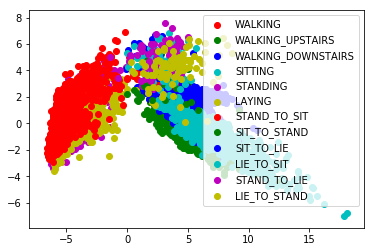

In [12]:
plot_PCA_2D(pcafeatures_train, target=y_train, target_names=np.array(activity['Activity'])) # np.array(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']))
            

In [13]:
pca_3D = PCA(n_components=3)
pca_3D.fit(X_train)
result=pd.DataFrame(pca_3D.transform(X_train), columns=['PCA%i' % i for i in range(3)], index=X_train.index)

<Figure size 432x288 with 0 Axes>

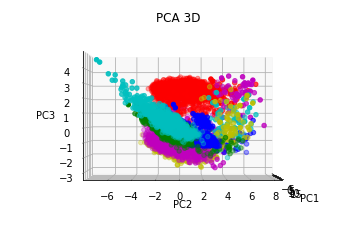

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Plot initialisation
fig = plt.figure()
 
    
def plot_PCA_3D(data, target, target_names):

    colors = cycle(['r','g','b','c','m','y'])
    target_ids = range(len(target_names))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i, c, label in zip(target_ids, colors, target_names):
        test = np.array(target == i)
        
        ax.scatter(data[test[:,0], 0], data[test[:,0], 1], data[test[:,0], 2],
                   c=c, label=label)
#         ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], s=60)


    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("PCA 3D")
#     plt.legend()


    for angle in range(0, 360):
        ax.view_init(0, 0)
        plt.draw()
        plt.pause(.001)

    #plt.show()
    
# Axes3D.scatter(xs, ys, zs=0, zdir='z', s=20, c=None, depthshade=True, *args, **kwargs)

plot_PCA_3D(pca_3D.transform(X_train), target=y_train, target_names=np.array(activity['Activity'])) 

### <span style="color:red">Need to make a 3d rotating plot</span> 

<Figure size 432x288 with 0 Axes>

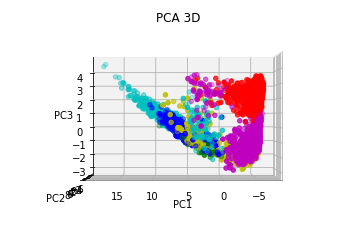

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [15]:
from mpl_toolkits.mplot3d import Axes3D

# Plot initialisation
fig = plt.figure()
 
    
def plot_PCA_3D(data, target, target_names):

    colors = cycle(['r','g','b','c','m','y'])
    target_ids = range(len(target_names))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i, c, label in zip(target_ids, colors, target_names):
        test = np.array(target == i)
        
        ax.scatter(data[test[:,0], 0], data[test[:,0], 1], data[test[:,0], 2],
                   c=c, label=label)
#         ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], s=60)


    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("PCA 3D")
#     plt.legend()


    for angle in range(0, 360):
        ax.view_init(0,90)
        plt.draw()
        plt.pause(.001)

    #plt.show()
    
# Axes3D.scatter(xs, ys, zs=0, zdir='z', s=20, c=None, depthshade=True, *args, **kwargs)

plot_PCA_3D(pca_3D.transform(X_train), target=y_train, target_names=np.array(activity['Activity'])) 

--------
## 3. Use GroupKFold to create a CV split

In [16]:
folds1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=47)

In [17]:
folds2 = StratifiedKFold(n_splits=5, shuffle=False, random_state=4)

In [18]:
from sklearn.model_selection import GroupKFold

grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

In [19]:
ExtraTreesClassifier()
GradientBoostingClassifier()
svm.SVC()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

--------
## 4. Fit Models on full feature space

In [20]:
models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('svm', svm.SVC),
          ('gnb', GaussianNB),
          ('bnb', BernoulliNB),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('erf', ExtraTreesClassifier)#,
#          ('boost', GradientBoostingClassifier),
         ]



param_choices = [
    {
        'n_neighbors': range(1, 100, 2)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'gamma': [.0001,.001,.01,.1, 'scale','auto_deprecated'], 
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    },
    {
        'var_smoothing' : [1e-10, 1e-9, 1e-8]
    },
    {
        'alpha': [.5, 1.0, 5],
        'binarize': [0.0, 6.0]
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [15, 20, None], 
        'max_features': [10, 15, 50, 'auto'],
        'min_samples_split': [2, 5, 25]
    },
    { 
        'max_features': [1, 10, 'auto'],
        'criterion': ['gini', 'entropy'],
        'n_estimators': [100, 200],
        'min_samples_split': [2,5,20],
        'min_impurity_decrease': [0, 1e-3, 1e-2],
        'bootstrap': [True,False],
        'max_depth': [3, 10, None] 
    }#, 
#     {
#         'n_estimators': [100, 200],
#         'criterion': ['friedman_mse', 'mse', 'mae'],
#         'max_depth': [3, 10], 
#         'max_features': [10, 'auto'],
#         'min_samples_split': [2, 5, 25],
#         'learning_rate': [.01,0.1,.5],
#         'subsample': [0.01, 0.1, 1],
#         'min_impurity_decrease': [0, 1e-3, 1e-2]
#     }
]

In [21]:
grid_outputs = {}

In [30]:
for model_info, params in zip(models, param_choices):

    grouped_kfold = GroupKFold(n_splits=3)
    groups = np.array(y_train_merged['SubjectID'])
    folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

    name, model = model_info
    grid = GridSearchCV(model(), params, cv=folds, n_jobs=-1)
    grid.fit(X_train, np.ravel(y_train))
    print(name)
    
    grid_outputs[name] = grid


knn


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logistic


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


svm


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


gnb
bnb
tree
forest


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


erf


In [32]:
for element in grid_outputs:
    print(element, grid_outputs[element].best_score_)

knn 0.869833912708
logistic 0.932277584653
svm 0.924552594309
gnb 0.667696665379
bnb 0.801210248487
tree 0.78846401442
forest 0.908973863783
erf 0.908458864426


In [31]:
best_fit_models = {}
predicted_y_values = {}

for element in grid_outputs:
    best_fit = grid_outputs[element].best_estimator_.fit(X_train, np.ravel(y_train))
    best_fit_models[element] = best_fit
    y_train_pred = best_fit.predict(X_train)
    predicted_y_values[element] = y_train_pred
    print(element, ": ", classification_report(y_train, y_train_pred), confusion_matrix(y_train, y_train_pred))
    

knn :                precision    recall  f1-score   support

           1       1.00      1.00      1.00      1226
           2       0.98      1.00      0.99      1073
           3       1.00      0.99      1.00       987
           4       0.96      0.92      0.94      1293
           5       0.94      0.96      0.95      1423
           6       0.99      1.00      1.00      1413
           7       0.84      0.87      0.85        47
           8       0.95      0.87      0.91        23
           9       0.81      0.91      0.86        75
          10       0.74      0.85      0.79        60
          11       0.96      0.71      0.82        90
          12       0.82      0.65      0.73        57

   micro avg       0.97      0.97      0.97      7767
   macro avg       0.92      0.89      0.90      7767
weighted avg       0.97      0.97      0.97      7767
 [[1226    0    0    0    0    0    0    0    0    0    0    0]
 [   0 1073    0    0    0    0    0    0    0    0    0    0]


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logistic :                precision    recall  f1-score   support

           1       1.00      1.00      1.00      1226
           2       1.00      1.00      1.00      1073
           3       1.00      1.00      1.00       987
           4       0.98      0.98      0.98      1293
           5       0.98      0.98      0.98      1423
           6       1.00      1.00      1.00      1413
           7       1.00      0.96      0.98        47
           8       1.00      1.00      1.00        23
           9       0.95      0.99      0.97        75
          10       0.98      0.98      0.98        60
          11       1.00      0.97      0.98        90
          12       0.98      0.95      0.96        57

   micro avg       0.99      0.99      0.99      7767
   macro avg       0.99      0.98      0.99      7767
weighted avg       0.99      0.99      0.99      7767
 [[1226    0    0    0    0    0    0    0    0    0    0    0]
 [   0 1073    0    0    0    0    0    0    0    0    0  

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


tree :                precision    recall  f1-score   support

           1       0.81      0.88      0.84      1226
           2       0.62      0.83      0.71      1073
           3       0.90      0.81      0.85       987
           4       0.90      0.90      0.90      1293
           5       0.91      0.91      0.91      1423
           6       1.00      0.99      0.99      1413
           7       0.00      0.00      0.00        47
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        75
          10       1.00      0.12      0.21        60
          11       0.00      0.00      0.00        90
          12       1.00      0.14      0.25        57

   micro avg       0.85      0.85      0.85      7767
   macro avg       0.59      0.46      0.47      7767
weighted avg       0.84      0.85      0.84      7767
 [[1075  101   50    0    0    0    0    0    0    0    0    0]
 [ 154  887   32    0    0    0    0    0    0    0    0    0]

### 4.6 Comparisons

--------
## 5. Feature Selection

In [19]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

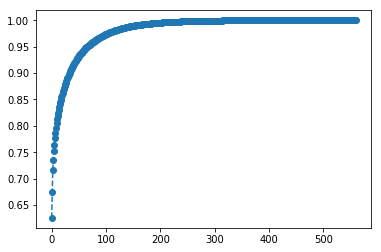

In [20]:
plt.plot(pca.explained_variance_ratio_.cumsum().reshape(561,1), '--o')

In [31]:
cumulative_varience_explained = pca.explained_variance_ratio_.cumsum().reshape(561,1)
cumulative_varience_explained = pd.DataFrame(cumulative_varience_explained)
cumulative_varience_explained.head()
# Need to keep 66 PCAs to get to 95% variability or 154 to keep 99% of variability

,0
0,0.625544
1,0.674675
2,0.715889
3,0.734639
4,0.751587


In [22]:
pca_99 = PCA(n_components=154)
pca_99.fit(X_train)
X_train_PCA = pd.DataFrame(pca_99.transform(X_train))

### <span style="color:red">Need to Turn this into a threshold formula^ </span>

--------
## 5. Fit Models on limited feature space

In [68]:
models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('boost', GradientBoostingClassifier),
          ('svm', svm.SVC)
         ]

param_choices = [
    {
        'n_neighbors': (1, 100)
    },
    {
        'C': (-3, 6, 'log-uniform'),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': (1,5),
        'min_samples_leaf': (1,10)
    },
    {
        'n_estimators': (50,300),
        'criterion': ['gini', 'entropy'],
        'max_depth': (2,50), 
        'max_features': (1,25),
        'min_samples_split': (2,50)
    },
    {
        'learning_rate': (.001,1,'log-uniform'), 
        'max_features': (1,25), 
        'subsample': (.001,1,'log-uniform'),
        'n_estimators': (50,300),
        'min_samples_split': (2,25)
    },
    {
        'gamma': (.001,1,'log-uniform'), 
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
]


bayes_grid_pca ={}
bayes_best_models_pca = {}
bayes_scores_pca = {}
bayes_parameters_pca = {}


for model_info, params in zip(models, param_choices):

    grouped_kfold = GroupKFold(n_splits=3)
    groups = np.array(y_train_merged['SubjectID'])
    folds = grouped_kfold.split(np.array(X_train_PCA), np.array(y_train), groups)

    name, model = model_info
    grid = BayesSearchCV(model(), params, cv=folds)
    bayes_grid_pca.fit(X_train_PCA, np.ravel(y_train))
    n = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best parameters: {grid.best_params_}"
    print(n)
    print(p)
    bayes_grid_pca[name] = grid
    bayes_best_models_pca[name]= grid.best_params_
    bayes_scores_pca[name] = grid.best_estimator_
    bayes_parameters_pca[name]= grid.best_params_

AttributeError: 'dict' object has no attribute 'fit'

In [29]:
models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('boost', GradientBoostingClassifier),
          ('svm', svm.SVC)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 50, 5)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [15, 20, None], 
        'max_features': [10, 15, 50, 'auto'],
        'min_samples_split': [2, 5, 25]
    },
    {
        'learning_rate': [.01,0.1,.5], 
        'max_features': [1, 10, "sqrt"], 
        'subsample': [0.01, 0.1, 1],
        'n_estimators': [100, 200, 400],
        'min_samples_split': [2,5,25]
    },
    {
        'gamma': [.0001,.001,.01,.1, 'scale','auto_deprecated'], 
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
]

grid_pca ={}
best_models_pca = {}
scores_pca = {}
parameters_pca = {}

for model_info, params in zip(models, param_choices):

    grouped_kfold = GroupKFold(n_splits=3)
    groups = np.array(y_train_merged['SubjectID'])
    folds = grouped_kfold.split(np.array(X_train_PCA), np.array(y_train), groups)

    name, model = model_info
    grid = GridSearchCV(model(), params, cv=folds, n_jobs=-1)
    grid.fit(X_train_PCA, np.ravel(y_train))
    n = f"{name}: best score: {grid.best_score_}"
    p = f"{name}: best parameters: {grid.best_params_}"
    print(n)
    print(p)
    grid_pca[name] = grid
    best_models_pca[name]= grid.best_params_
    scores_pca[name] = grid.best_estimator_
    parameters_pca[name]= grid.best_params_
    

knn: best score: 0.8820729053318824
knn: best score: {'n_neighbors': 16}


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logistic: best score: 0.9228781284004353
logistic: best score: {'C': 1.873817422860385, 'penalty': 'l2'}
tree: best score: 0.7759793253536452
tree: best score: {'max_depth': 5, 'min_samples_leaf': 6}


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


forest: best score: 0.8819368879216539
forest: best score: {'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 5, 'n_estimators': 200}


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


boost: best score: 0.9056039173014145
boost: best score: {'learning_rate': 0.1, 'max_features': 'sqrt', 'min_samples_split': 25, 'n_estimators': 400, 'subsample': 1}
svm: best score: 0.9224700761697497
svm: best score: {'gamma': 0.01, 'kernel': 'rbf'}


In [65]:
print(grid.best_estimator_)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## 6. Testing our chosen model

In [60]:
features = pd.read_csv('HAPT Data Set/features.txt', delim_whitespace=True, header=None)
activity = pd.read_csv('HAPT Data Set/activity_labels.txt', delim_whitespace=True, header=None)
subject_test = pd.read_csv('HAPT Data Set/test/subject_id_test.txt', delim_whitespace=True, header=None)
X_test = pd.read_csv('HAPT Data Set/test/X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('HAPT Data Set/test/y_test.txt', delim_whitespace=True, header=None)

In [61]:
y_test[0].unique()

array([ 5,  7,  4,  8, 11,  6, 10,  9, 12,  1,  3,  2])

In [62]:
grid_outputs_test={}

In [63]:
predicted_y_values = {}


for element in grid_outputs:
    y_test_pred = best_fit_models[element].predict(X_test)
    predicted_y_values[element]=y_test_pred
    print(element, ": ", accuracy_score(y_test, y_test_pred), classification_report(y_test, y_test_pred), confusion_matrix(y_test, y_test_pred))


knn :  0.89247311828               precision    recall  f1-score   support

           1       0.85      0.98      0.91       496
           2       0.88      0.91      0.89       471
           3       0.97      0.79      0.87       420
           4       0.90      0.80      0.85       508
           5       0.84      0.92      0.88       556
           6       1.00      0.99      1.00       545
           7       0.89      0.74      0.81        23
           8       1.00      1.00      1.00        10
           9       0.64      0.88      0.74        32
          10       0.65      0.88      0.75        25
          11       0.77      0.47      0.58        49
          12       0.85      0.41      0.55        27

   micro avg       0.89      0.89      0.89      3162
   macro avg       0.85      0.81      0.82      3162
weighted avg       0.90      0.89      0.89      3162
 [[487   2   7   0   0   0   0   0   0   0   0   0]
 [ 37 429   5   0   0   0   0   0   0   0   0   0]
 [ 44  43 

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


tree :  0.779886148008               precision    recall  f1-score   support

           1       0.70      0.90      0.79       496
           2       0.59      0.79      0.67       471
           3       0.90      0.62      0.74       420
           4       0.78      0.81      0.79       508
           5       0.82      0.80      0.81       556
           6       1.00      0.98      0.99       545
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        32
          10       0.00      0.00      0.00        25
          11       0.00      0.00      0.00        49
          12       0.00      0.00      0.00        27

   micro avg       0.78      0.78      0.78      3162
   macro avg       0.40      0.41      0.40      3162
weighted avg       0.76      0.78      0.76      3162
 [[446  32  18   0   0   0   0   0   0   0   0   0]
 [ 89 372  10   0   0   0   0   0   0   0   0   0]
 [ 95  6

In [64]:
predicted_y_values

{'knn': array([5, 5, 5, ..., 2, 2, 1]),
 'logistic': array([5, 5, 5, ..., 2, 2, 2]),
 'svm': array([5, 5, 5, ..., 2, 2, 2]),
 'gnb': array([5, 5, 4, ..., 2, 2, 2]),
 'bnb': array([5, 5, 5, ..., 2, 2, 2]),
 'tree': array([5, 5, 5, ..., 2, 2, 2]),
 'forest': array([5, 5, 5, ..., 2, 2, 2]),
 'erf': array([5, 5, 5, ..., 2, 2, 2])}

In [65]:
confusion_matrix(y_test, predicted_y_values['logistic'])

array([[491,   3,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 27, 443,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  5,   6, 409,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   4,   0, 444,  59,   0,   0,   0,   0,   0,   1,   0],
       [  2,   0,   0,  12, 542,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 545,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   2,   2,   0,  16,   0,   1,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,  10,   0,   0,   0,   0],
       [  0,   0,   0,   1,   1,   0,   0,   0,  25,   0,   4,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  18,   0,   7],
       [  2,   1,   0,   3,   0,   1,   0,   0,  11,   0,  31,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0,   8,   3,  15]])

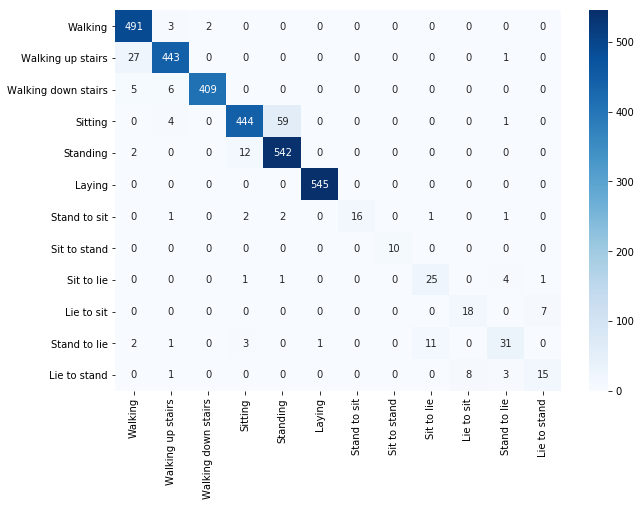

In [66]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(y_test, predicted_y_values['logistic'])

act = ['Walking', 'Walking up stairs', 'Walking down stairs', 'Sitting', 'Standing', 'Laying', "Stand to sit", 'Sit to stand', 'Sit to lie', 'Lie to sit', 'Stand to lie', 'Lie to stand']

df_cm = pd.DataFrame(array, index = [i for i in act],
                  columns = [i for i in act])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
plt.rcParams['font.size'] = 20


## Oversample Minority

In [67]:
y_test.columns=["ActivityID"]
df = pd.concat([X_test, y_test], axis=1)

In [81]:
minority = df[df['ActivityID']>6].reset_index()
minority = minority.drop(['index'], axis=1)

In [88]:
frames = [minority, minority, minority, minority, minority, minority, minority, minority, minority, minority, minority, minority, minority, minority, minority, minority, minority, minority, minority, minority]
expanded = pd.concat(frames)

In [90]:
df_expanded = pd.concat([df,expanded], axis=0)

In [96]:
y_test_expanded = df_expanded['ActivityID']
X_test_expanded = df_expanded[list(range(561))]

In [100]:
predicted_y_values_expanded = {}


for element in grid_outputs:
    y_test_pred_expanded = best_fit_models[element].predict(X_test_expanded)
    predicted_y_values_expanded[element]=y_test_pred_expanded
    print(element, ": ", accuracy_score(y_test_expanded, y_test_pred_expanded), classification_report(y_test_expanded, y_test_pred_expanded), confusion_matrix(y_test_expanded, y_test_pred_expanded))


knn :  0.777846343721               precision    recall  f1-score   support

           1       0.77      0.98      0.86       496
           2       0.64      0.91      0.75       471
           3       0.97      0.79      0.87       420
           4       0.83      0.80      0.81       508
           5       0.81      0.92      0.86       556
           6       0.96      0.99      0.98       545
           7       0.89      0.74      0.81       483
           8       1.00      1.00      1.00       210
           9       0.64      0.88      0.74       672
          10       0.65      0.88      0.75       525
          11       0.77      0.47      0.58      1029
          12       0.85      0.41      0.55       567

   micro avg       0.78      0.78      0.78      6482
   macro avg       0.81      0.81      0.80      6482
weighted avg       0.80      0.78      0.77      6482
 [[487   2   7   0   0   0   0   0   0   0   0   0]
 [ 37 429   5   0   0   0   0   0   0   0   0   0]
 [ 44  43

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


erf :  0.783245911756               precision    recall  f1-score   support

           1       0.85      0.97      0.91       496
           2       0.71      0.94      0.81       471
           3       0.96      0.84      0.89       420
           4       0.85      0.89      0.87       508
           5       0.91      0.97      0.94       556
           6       1.00      1.00      1.00       545
           7       0.81      0.74      0.77       483
           8       0.89      0.80      0.84       210
           9       0.70      0.81      0.75       672
          10       0.59      0.68      0.63       525
          11       0.72      0.59      0.65      1029
          12       0.58      0.41      0.48       567

   micro avg       0.78      0.78      0.78      6482
   macro avg       0.80      0.80      0.79      6482
weighted avg       0.78      0.78      0.78      6482
 [[483   3  10   0   0   0   0   0   0   0   0   0]
 [ 25 441   5   0   0   0   0   0   0   0   0   0]
 [ 18  50

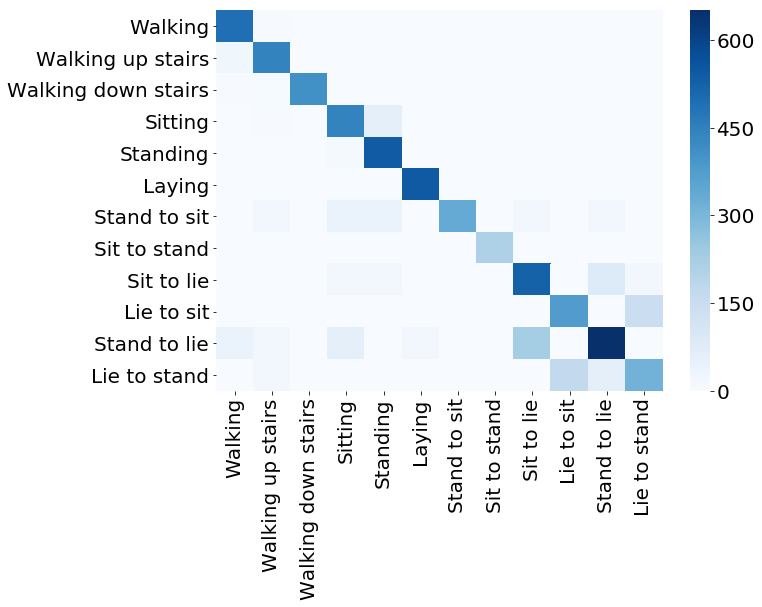

In [102]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(y_test_expanded, predicted_y_values_expanded['logistic'])

act = ['Walking', 'Walking up stairs', 'Walking down stairs', 'Sitting', 'Standing', 'Laying', "Stand to sit", 'Sit to stand', 'Sit to lie', 'Lie to sit', 'Stand to lie', 'Lie to stand']

df_cm = pd.DataFrame(array, index = [i for i in act],
                  columns = [i for i in act])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=False, fmt='g', cmap="Blues")
plt.rcParams['font.size'] = 20


-------------
-------------
-------------

## Appendix

In [ ]:
# # THIS ONLY WORKS FOR BINARY CLASSIFICATION. I NEED ANOTHER VERSION FOR MULTI CLASS

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve,auc

# knn_roc_auc = roc_auc_score(y_train, pred_train_knn_best)
# fpr, tpr, thresholds = roc_curve(y_train, knn_best_cv.predict_proba(X_train)[:,1])
# roc_auc = auc(fpr,tpr)

# plt.figure(figsize=(6,6))
# # Plotting our Baseline..
# plt.plot([0,1],[0,1],'r--')
# plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
# plt.legend(loc='lower right')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate');

In [ ]:
grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

KNN_best_CV_train_pred = cross_val_predict(
    knn_best, 
    X_train, 
    np.ravel(y_train), 
    cv=folds,
    method=’predict’)

KNN_best_CV_train_pred_proba = cross_val_predict(
    knn_best, 
    X_train, 
    np.ravel(y_train), 
    cv=folds,
    method=’predict_proba’)


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

knn_roc_auc = roc_auc_score(y_train, KNN_best_CV_train_pred)
fpr, tpr, thresholds = roc_curve(y_train, KNN_best_CV_train_pred_proba[:,1])
roc_auc = auc(fpr,tpr)

In [101]:
# How to get ROC Curves

# Here I generate grouped k-folds
from sklearn.model_selection import GroupKFold
grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)


# Here I fit a model using GridSearchCV to iterate through different K values 
# and cross validate using my predefined folds to find best K value
param_grid = dict(n_neighbors=list(range(1, 100,5)))
knn = KNeighborsClassifier(n_neighbors=13)
grid_knn = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train['ActivityID']);
knn_best = grid_knn.best_estimator_

# I could fit my model on the full X_train dataset and then predict the y_trains.
# This will tend to give me higher accuracy because of overfitting and/or sample size effects
# If I want to build an ROC curve, this will tend to show my model performing better than it 
# would on test data because I am only capturing the in-sample error rate
knn_best.fit(X_train, np.ravel(y_train))
pred_train_knn_best = knn_best.predict(X_train)


# If I want to build an ROC curve we want to predict y as below. This method essentially predicts each y_i
# based on a model fit on the subset of X_train that excludes the fold in which y_i was contained
pred_train_KNN_best_CV = cross_val_predict(
    knn_best, 
    X_train, 
    np.ravel(y_train), 
    cv=folds)

# In summary:
# pred_train_knn_best - predicts all y_i's on the same model which was fit on all of X_train
# pred_train_KNN_best_CV  - each y_i is predicted with a model trained on out of sample folds

SyntaxError: invalid syntax (<ipython-input-101-4f19b24d1236>, line 11)

In [ ]:
model_svm_linear = svm.SVC(kernel='linear')
model_svm_linear.fit(X_train, y_train)

In [ ]:
pred_train_svm_linear = model_svm_linear.predict(X_train)
confusion_matrix(y_train, pred_train_svm_linear)

In [ ]:
from sklearn.metrics import confusion_matrix
accuracy_score(y_train, pred_train_svm_linear)

In [ ]:
model_svm_rbf = svm.SVC(kernel='rbf')
model_svm_rbf.fit(X_train, y_train)
pred_train_svm_rbf = model_svm_rbf.predict(X_train)

In [ ]:
accuracy_score(y_train, pred_train_svm_rbf)

### 4.1 KNN

In [18]:
from sklearn.model_selection import GroupKFold

grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

In [222]:
k_range = list(range(1, 100,5))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier(n_neighbors=13)

In [223]:
grid_knn = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy', n_jobs=-1)

In [224]:
grid_knn.fit(X_train, y_train['ActivityID']);

In [225]:
print(grid_knn.best_score_)
print(grid_knn.best_params_)
print(grid_knn.best_estimator_)

# went from ?90? to 88, K stayed 16 (before & after grouping kfolds)

0.882889009793
{'n_neighbors': 16}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=16, p=2,
           weights='uniform')


In [23]:
knn_best = grid_knn.best_estimator_
knn_best.fit(X_train, np.ravel(y_train))
pred_train_knn_best = knn_best.predict(X_train)

In [24]:
accuracy_score(y_train, pred_train_knn_best)

0.9683079434167573

In [25]:
confusion_matrix(y_train, pred_train_knn_best)


array([[1226,    0,    0,    0,    0,    0],
       [   6, 1067,    0,    0,    0,    0],
       [   8,    9,  969,    0,    0,    0],
       [   0,    1,    0, 1147,  133,    5],
       [   0,    0,    0,   68, 1306,    0],
       [   0,    0,    1,    2,    0, 1404]])

### 4.2 SVM

In [26]:
model_svm = svm.SVC(kernel='rbf', gamma='auto_deprecated')

# may want to add random_state=86 to be safe

In [28]:
param_grid_svm = {'gamma':[.0001,.001,.01,.1, 'scale','auto_deprecated'], 
              'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

In [29]:
grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)

In [30]:
grid_svm = GridSearchCV(model_svm, param_grid_svm, cv=folds, scoring='accuracy', n_jobs=-1)

In [31]:
grid_svm.fit(X_train, y_train['ActivityID']);

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [32]:
print(grid_svm.best_score_)
print(grid_svm.best_params_)
print(grid_svm.best_estimator_)

0.924102285092
{'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Before grouping our K-Folds, we believe the best option will be to use a linear model with gamma=0.01

After grouping K folds, the best is rbf with gamma of 0.01

In [33]:
svc_best = grid_svm.best_estimator_
svc_best.fit(X_train, np.ravel(y_train))
# y_pred = knn.predict(X_test)
# print(metrics.accuracy_score(y_test, y_pred))
pred_train_svc_best = svc_best.predict(X_train)

In [34]:
accuracy_score(y_train, pred_train_svc_best)

0.98340587595212192

In [35]:
confusion_matrix(y_train, pred_train_svc_best)

array([[1226,    0,    0,    0,    0,    0],
       [   1, 1071,    1,    0,    0,    0],
       [   0,    0,  986,    0,    0,    0],
       [   0,    1,    0, 1231,   54,    0],
       [   0,    0,    0,   65, 1309,    0],
       [   0,    0,    0,    0,    0, 1407]])

### 4.3 Random Forest

In [37]:
model_randforest = RandomForestClassifier(
    n_estimators=200, 
    criterion='gini', 
    max_depth=None, 
    max_features='auto',
    min_samples_split=5,
    random_state=47)

In [38]:
''' First time tried below model and got cv accuracy of 0.898394994559 
and in-sample of 1.0 so we definitely overfit'''

# param_grid_randforrest = {
#     'criterion':['gini', 'entropy'],
#     'max_depth':[None, 50,100], 
#     'max_features':['auto', 50]
# }

param_grid_randforest = {
    'n_estimators':[50, 200],
    'criterion':['gini', 'entropy'],
    'max_depth':[15, 20, None], 
    'max_features':[10, 15, 50, 'auto'],
    'min_samples_split':[2, 5, 25]
}



In [39]:
from sklearn.model_selection import GroupKFold

grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)


grid_randforest = GridSearchCV(model_randforest, param_grid_randforest, cv=folds, scoring='accuracy', n_jobs=-1)
grid_randforest.fit(X_train, np.ravel(y_train))

print(grid_randforest.best_score_)
print(grid_randforest.best_params_)
print(grid_randforest.best_estimator_)

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.906147986942
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=47, verbose=0, warm_start=False)


In [40]:
randforest_best = grid_randforest.best_estimator_
randforest_best.fit(X_train, np.ravel(y_train))

# y_pred = knn.predict(X_test)
# print(metrics.accuracy_score(y_test, y_pred))
pred_train_randforest_best = randforest_best.predict(X_train)

In [41]:
accuracy_score(y_train, pred_train_randforest_best)

1.0

In [42]:
confusion_matrix(y_train, pred_train_randforest_best)

array([[1226,    0,    0,    0,    0,    0],
       [   0, 1073,    0,    0,    0,    0],
       [   0,    0,  986,    0,    0,    0],
       [   0,    0,    0, 1286,    0,    0],
       [   0,    0,    0,    0, 1374,    0],
       [   0,    0,    0,    0,    0, 1407]])

### <span style="color:red">Need to analyze an extra random forest i.e. random feature selection, not greedy. Is that the same as entropy? </span>

### 4.4 Gradient Boosting

In [44]:
model_gradboost = GradientBoostingClassifier(learning_rate=0.1, max_features=1, subsample=0.5,
n_estimators=200, min_samples_split=5)

In [50]:
param_grid_gradboost = {
    'learning_rate':[.01,0.1,.5], 
    'max_features':[1, 10, "sqrt"], 
    'subsample':[0.01, 0.1, 1],
    'n_estimators':[100, 200, 400],
    'min_samples_split':[2,5,25]
}

In [51]:

grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)


grid_gradboost = GridSearchCV(model_gradboost, param_grid_gradboost, cv=folds, scoring='accuracy', n_jobs=-1)
grid_gradboost.fit(X_train, np.ravel(y_train));

print(grid_gradboost.best_score_)
print(grid_gradboost.best_params_)
print(grid_gradboost.best_estimator_)

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.908596300326
{'learning_rate': 0.1, 'max_features': 10, 'min_samples_split': 2, 'n_estimators': 400, 'subsample': 0.1}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=10, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [52]:
gradboost_best = grid_gradboost.best_estimator_
gradboost_best.fit(X_train, np.ravel(y_train))
# y_pred = knn.predict(X_test)
# print(metrics.accuracy_score(y_test, y_pred))
pred_train_gradboost_best = gradboost_best.predict(X_train)

In [53]:
accuracy_score(y_train, pred_train_gradboost_best)

1.0

In [54]:
confusion_matrix(y_train, pred_train_gradboost_best)

array([[1226,    0,    0,    0,    0,    0],
       [   0, 1073,    0,    0,    0,    0],
       [   0,    0,  986,    0,    0,    0],
       [   0,    0,    0, 1286,    0,    0],
       [   0,    0,    0,    0, 1374,    0],
       [   0,    0,    0,    0,    0, 1407]])

### 4.5 Logistic Regression

In [57]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)

In [26]:

model_log_L2 = LogisticRegression(n_jobs=-1, C=1.0, tol=0.0001, solver ='newton-cg', max_iter=100, random_state = 42, multi_class='auto')


In [56]:
param_grid_log_L2 = {
    'C':[.05, .1, .5], 
#     'penalty':['l2','l1'],
    'tol':[0.000001, 0.0001, 0.001],
    'solver':['newton-cg', 'lbfgs', 'sag'],
    'max_iter':[100, 500]
}

In [ ]:
from skopt import gp_minimize


class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')```

In [58]:
from sklearn.model_selection import GroupKFold

grouped_kfold = GroupKFold(n_splits=3)
groups = np.array(y_train_merged['SubjectID'])
folds = grouped_kfold.split(np.array(X_train), np.array(y_train), groups)


grid_log = GridSearchCV(model_log, param_grid_log, cv=folds, scoring='accuracy', n_jobs=-1)
grid_log.fit(X_train_scaled, np.ravel(y_train));

print(grid_log.best_score_)
print(grid_log.best_params_)
print(grid_log.best_estimator_)

0.912812840044
{'C': 0.5, 'max_iter': 500, 'solver': 'sag', 'tol': 1e-06}
LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto', n_jobs=-1,
          penalty='l2', random_state=42, solver='sag', tol=1e-06,
          verbose=0, warm_start=False)


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [59]:
log_best = grid_log.best_estimator_
# y_pred = knn.predict(X_test)
# print(metrics.accuracy_score(y_test, y_pred))
pred_train_log_best = log_best.predict(X_train_scaled)

/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [60]:
accuracy_score(y_train, pred_train_log_best)

0.98680631120783457

In [61]:
confusion_matrix(y_train, pred_train_log_best)

array([[1225,    1,    0,    0,    0,    0],
       [   0, 1073,    0,    0,    0,    0],
       [   0,    0,  986,    0,    0,    0],
       [   0,    0,    0, 1236,   50,    0],
       [   0,    0,    0,   46, 1328,    0],
       [   0,    0,    0,    0,    0, 1407]])